In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sm

In [205]:
class Matrix():
    '''
    a large array with initial data for all three periods
    '''
    def __init__(self, FilePath):
        with open(FilePath) as genoms_file:
            genoms = genoms_file.read()
        NASdict = {}
        NamesAndSequence = genoms.split('>')
        for NameAndSeq in NamesAndSequence[1:]:
            start = NameAndSeq.find('\n')
            NASdict[f'{NameAndSeq[:start]}'] = list(NameAndSeq[start+1:].replace('\n','').upper())
        self.df = pd.DataFrame.from_dict(NASdict, orient='index', 
                            columns=range(1,len(NASdict[f'{NamesAndSequence[-1][:start]}'])+1))

    def Separation(self):
        """
        It divides into 3 separate objects
        """
        dict1 = {}
        dict2 = {}
        dict3 = {}
        for name in self.df.index:
            if 'hiv1' in name:
                dict1[name] = self.df.loc[name]
            elif 'hiv2' in name:
                dict2[name] = self.df.loc[name]
            elif 'hiv3' in name:
                dict3[name] = self.df.loc[name]
        df1 = pd.DataFrame.from_dict(dict1, orient='index')
        df2 = pd.DataFrame.from_dict(dict2, orient='index')
        df3 = pd.DataFrame.from_dict(dict3, orient='index')
        m1 = MiniMatrix()
        m1.df = df1
        m2 = MiniMatrix()
        m2.df = df2
        m3 = MiniMatrix()
        m3.df = df3
        return m1, m2, m3

class MiniMatrix():
    def ColumnsCleaning(self, SiteGapsThreshold, SiteMonomorphThreshold):
        DropList = []
        N = self.df.shape[0]
        TN = N*SiteMonomorphThreshold
        sm = self.df.sum().copy()
        for i in self.df.columns:
            if sm[i]<=TN:
                DropList.append(i)
        self.df.drop(DropList, inplace=True, axis=1)
        '''
        Deletes a column if there are too many gaps in it.
        '''
        for i in self.df.columns:
            if '-' in self.df.loc[:, i].value_counts():
                if self.df.loc[:, i].value_counts()['-']/self.df.shape[0]<=SiteGapsThreshold:
                    DropList.append(i)
        '''
        Deletes a column if it contains less than a certain number of items other than consensus
        '''
        SiteMonomorphThreshold = 1-SiteMonomorphThreshold
        for i in self.df.columns:
#             if len(self.df.loc[:,i].value_counts())>=2:
            if self.df.loc[:,i].value_counts().max()/self.df.shape[0]<=SiteMonomorphThreshold:
                DropList.append(i)
#             if len(self.df.loc[:,i].value_counts())==1:
#                 DropList.append(i)
        DropList = list(set(DropList))
        self.df.drop(DropList, inplace=True, axis=1)
        
        for i in self.df.columns:
            # SiteMonomorphThreshold = 1-SiteMonomorphThreshold
            if self.df.loc[:,i].value_counts().min()/self.df.shape[0]>=SiteMonomorphThreshold:
                DropList.append(i)
        self.DropList = list(set(DropList))
        self.df.drop(DropList, inplace=True, axis=1)

    def IndexCleaning(self, SeqGapsThreshold):
        """
        Deletes a sequence if there are too many gaps in it.
        """
        DropList = []
        for i in self.df.index:
            if '-' in self.df.loc[i, :].value_counts():
                if self.df.loc[i, :].value_counts()['-']/self.df.shape[1]<=SeqGapsThreshold:
                    DropList.append(i)
#         print(DropList)
        self.df.drop(DropList, inplace=True)

    def Binarization(self):
        """
        Converts it to binary format. 0 is a more common option. 1 - mutations
        """
        for i in self.df.columns:
            self.df.loc[self.df[i] == self.df.loc[:,i].value_counts().idxmax(), i] = 0
            self.df.loc[self.df[i] != self.df.loc[:,i].value_counts().idxmax(), i] = 1

In [206]:
class Graphs():
    
    def __init__(self, m1, m2, m3, C=0, SearchIntersection=False):
        

        self.C=C
        
        self.df1 = m1.df
        self.df2 = m2.df
        self.df3 = m3.df
        

        self.set1 = set(self.df1.columns)
        self.set2 = set(self.df2.columns)
        self.set3 = set(self.df3.columns)
        self.set12 = self.set1 & self.set2
        self.set13 = self.set1 & self.set3
        self.set23 = self.set2 & self.set3
        self.set123 = self.set1 & self.set2 & self.set3

        CountDict1 = (self.df1.sum()/(np.shape(self.df1)[0])).loc[list(self.set123)].to_dict()

        CountDict2 = (self.df2.sum()/(np.shape(self.df2)[0])).loc[list(self.set123)].to_dict()
                
        CountDict3 = (self.df3.sum()/(np.shape(self.df3)[0])).loc[list(self.set123)].to_dict()
        self.Dict123 = {1:CountDict1, 2:CountDict2, 3:CountDict3}

        self.Frame123 = pd.DataFrame(self.Dict123)
        self.Frame123 = self.Frame123.loc[list(self.set123)]
        self.Frame123.loc[:,'mean'] = self.Frame123.mean(axis=1)
        
        
        self.new_ids = list(self.Frame123.sort_values('mean', axis=0, ascending=True).index)
        self.SortFrame = self.Frame123.sort_values('mean', axis=0, ascending=True)
        self.logFrame = np.log((1-self.SortFrame)/self.SortFrame)
        
        
        self.SearchIntersection = SearchIntersection
        
        self.x=np.arange(1,len(self.new_ids)+1)
        self.y=(self.logFrame.loc[:,1].to_numpy())
        self.y2=(self.logFrame.loc[:,2].to_numpy())
        self.y3=(self.logFrame.loc[:,3].to_numpy())
        
        self.yDict = dict()
        for n in range(1,4):
            self.yDict[f'y_{n}'] = self.logFrame.loc[:,n].to_numpy()
            
        if self.SearchIntersection:
            x=np.arange(1,100,0.01)
            self.polyDict = dict()
            for n in range(1,4):
                self.polyDict[f'line_{n}']=np.poly1d(np.polyfit(self.x,self.yDict[f'y_{n}'],4))
            absDict=dict()
            ncount=1
            for i in range(1,4):
                for j in range(i+1,4):
                    absDict[f'abs{ncount}']=[]
                    for z in x:
                        absDict[f'abs{ncount}'].append((self.polyDict[f'line_{j}'](z)-self.polyDict[f'line_{i}'](z))**2)
                    ncount+=1
            self.absdf=pd.DataFrame(absDict,index=x)
            self.absdf['sum']=self.absdf.sum(axis=1)
            self.x0=self.absdf[self.absdf['sum']==self.absdf['sum'].min()].index[0]
            self.C=np.mean([self.polyDict[f'line_{n}'](self.x0) for n in range(1,4)])
        self.table_s = self.logFrame.sort_index().T.loc[1:3,:]-self.C

        
        if self.SearchIntersection:    
            line_1 = LineString(np.column_stack((self.x, poly(self.x,self.y))))
            line_2 = LineString(np.column_stack((self.x, poly(self.x,self.y2))))
            line_3 = LineString(np.column_stack((self.x, poly(self.x,self.y3))))
            intersection12 = line_1.intersection(line_2)
            intersection13 = line_1.intersection(line_3)
            intersection32 = line_3.intersection(line_2)
            self.x0 = (intersection12.xy[0][0]+intersection13.xy[0][0]+intersection32.xy[0][0])/3
            self.C = (intersection12.xy[1][0]+intersection13.xy[1][0]+intersection32.xy[1][0])/3
            
            self.table_poly_s = pd.DataFrame([poly(self.x,self.y),
                       poly(self.x,self.y2),poly(self.x,self.y3)],
             columns=self.SortFrame.index, index=range(1,4)).T.sort_index().T-self.C
            self.table_s = self.logFrame.sort_index().T.loc[1:3,:]-self.C
        
        


    def PrintL(self):
        '''
        Shows how many sites are left and how many intersections 
        there are on the remaining sites between periods
        '''
        texts = ['L1', 'L2', 'L3', 'L12', 'L13', 'L23', 'L123']
        sets = [self.set1, self.set2, self.set3, self.set12, self.set13, self.set23, self.set123]
        for i in range(7):
            print(texts[i],'=',str(len(sets[i])))
            


    def sMeasureLine(self, Mean=False, 
                     axis = 'valueAxis'):
        """
        makes a graph of beta*s dependence on websites
        """
        
        plt.figure(figsize=(6,4), dpi = 200)
        plt.xlabel('$m_i$')
        plt.ylabel('$\\beta(t) \\cdot s_i$')
        
        
        if axis == 'valueAxis':    
            plt.plot(range(1,len([f"{idx}" for idx in self.new_ids])+1), 
                     (self.logFrame.loc[:,1].to_numpy()-self.C),
                     '.-',color='C0',label='t=2555')
            plt.plot(range(1,len([f"{idx}" for idx in self.new_ids])+1), 
                     (self.logFrame.loc[:,2].to_numpy()-self.C),
                     '.-',color='C1',label='t=3285')
            plt.plot(range(1,len([f"{idx}" for idx in self.new_ids])+1), 
                     (self.logFrame.loc[:,3].to_numpy()-self.C),
                     '.-',color='C2',label='t=4015')
            if Mean:
                plt.plot(range(1,len([f"{idx}" for idx in self.new_ids])+1), 
                         (self.logFrame.loc[:,'mean'].to_numpy()-self.C),
                         '.--',color='k',label='mean')
            
        elif axis =='unvalueAxis':
            for n in range(1,len(self.mat['Data'][0][0][0])+1):
                plt.plot(self.x, self.yDict[f'y_{n}']-self.C,'.-',
                         label=f'{self.mat["tsecs"][0][n-1]}',color=f'C{n-1}')
            if Mean:
                plt.plot(self.x,(self.logFrame.loc[:,'mean'].to_numpy()-self.C),
                         '.--',color='k',label='mean')
         
        plt.legend()
        if self.SearchIntersection:
            plt.plot(self.x0,0,'ok')
            ax = plt.gca()
            ax.axhline(y=0, color='k',ls=':')   
    
    def PolyS(self):
        plt.figure(figsize=(6,4), dpi = 200)
        plt.xlabel('$m_i$')
        plt.ylabel('$\\beta(t) \\cdot s_i$')
        for n in range(1,4):
            plt.plot(self.x, self.yDict[f'y_{n}'],'.-',alpha=0.3, 
                     color=f'C{n-1}',label=f't={n}')
            plt.plot(np.linspace(1,max(self.x),50), self.polyDict[f'line_{n}'](np.linspace(1,max(self.x),50)), 
                     color=f'C{n-1}')
        plt.legend()    
        if self.SearchIntersection:
            plt.plot(self.x0,self.C,'ok')

    def sMeasureHist(self, Interpol=False,mean=False):
        """
        A histogram of s values for each site
        """
        if Interpol==False:
            for j in range(1,4):
                plt.figure(figsize=(16,4), dpi=200)
                plt.bar(list(self.logFrame.T.columns), 
                        [i for i in (self.table_s).values[j-1]],
                        bottom=None,label='real')
                plt.grid()
            plt.ylabel('$\\beta(t) \\cdot s_i$')
        else:
            for j in range(1,len(self.mat['Data'][0][0][0])+1):
                plt.figure(figsize=(16,4), dpi=300)
                plt.bar(np.array(self.logFrame.T.columns), 
                        [i for i in (self.table_poly_s).values[j-1]],
                        bottom=None, alpha=0.4, color='green',label='poly')
                plt.bar(list(self.logFrame.T.columns), 
                        [i for i in (self.table_s).values[j-1]],
                        bottom=None, alpha=0.4, color='red',label='real')
                plt.legend()
                plt.ylabel(f'$\\beta({self.mat["tsecs"][0][j-1]}) \\cdot s_i$')
                plt.xlabel('nomber of genomic site')
        if mean:
            plt.figure(figsize=(16,4), dpi=300)
            plt.bar(list(self.logFrame.T.columns),self.meanPolyBeta,
                    bottom=None, alpha=0.4, color='green',label='poly')
            plt.bar(list(self.logFrame.T.columns),self.meanBeta,
                    bottom=None, alpha=0.4, color='red',label='real')
            plt.legend()
            plt.ylabel('$\\beta_{mean} \\cdot s_i$')
            plt.xlabel('nomber of genomic site')

In [207]:
path1 = 'path to a .fas file with aligned sequences'
M = Matrix(path1)

In [208]:
m1,m2,m3 = M.Separation()

In [209]:
SeqGapsThreshold = 0.05
SiteGapsThreshold = 0.06
SiteMonomorphThreshold = 0.06
for m in [m1,m2,m3]:
    m.IndexCleaning(SeqGapsThreshold)
    m.Binarization()
    m.ColumnsCleaning(SiteGapsThreshold, SiteMonomorphThreshold)

In [211]:
gr = Graphs(m1,m2,m3, SearchIntersection=False)

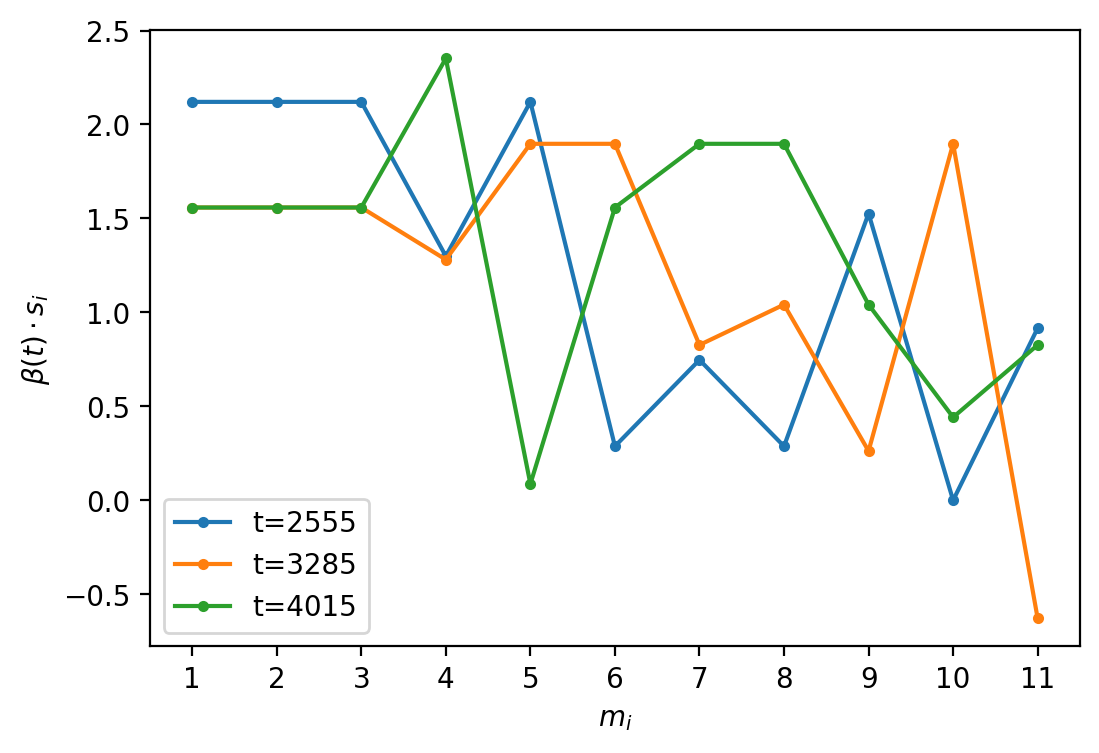

In [213]:
gr.sMeasureLine(Mean=False)
plt.xticks(range(1,len(gr.set123)+1));